# Demo 2: Support Vector Machine (SVM) Classification


git hub link https://github.com/jeentk17/introto-ai-thanakrit/blob/main/demo2_svm.ipynb

## Problem & Data
We solve a simple **binary classification** task with synthetic data (X = features, y = labels).  
Goal: train an SVM to separate two classes.
## How SVM Works
SVM finds a boundary (hyperplane) that maximizes the margin between classes.  
- `C`: regularization (fit tight vs allow margin)  
- `gamma`: controls boundary curve (higher = more complex)  
- `kernel`: linear, rbf, poly  

We use a pipeline (Scaler + SVC) and GridSearchCV to find the best parameters.


### Importing Libraries
This cell imports all necessary Python libraries for data generation, preprocessing, model building, evaluation, and visualization. Key libraries include scikit-learn for machine learning, matplotlib for plotting, and numpy for numerical operations.

In [ ]:
# Imports: numpy, matplotlib, sklearn modules for SVM classification
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, RocCurveDisplay
from sklearn.decomposition import PCA

### Setting Up Output Directory
This cell creates a folder to save all generated results and plots. Organizing outputs helps keep experiment results accessible and reproducible.

In [ ]:
# Setup output directory for saving results
SCRIPT_DIR = os.getcwd()
OUT_DIR = os.path.join(SCRIPT_DIR, "introai2")
os.makedirs(OUT_DIR, exist_ok=True)
print("Saving to:", OUT_DIR)

Saving to: c:\Users\Jeen\Desktop\introai\introai2\introai2


### Data Generation and Splitting
This cell creates a synthetic classification dataset using `make_classification`. The dataset has 500 samples, 20 features (6 informative, 2 redundant), and a binary target label (0 or 1). The data is then split into training and test sets to evaluate model performance on unseen data.

In [ ]:
# Generate synthetic classification data using make_classification
X, y = make_classification(
    n_samples=500,
    n_features=20,
    n_informative=6,
    n_redundant=2,
    n_clusters_per_class=2,
    class_sep=1.2,
    flip_y=0.02,
    random_state=42,
)
# Split data into train and test sets using train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

### Building the SVM Pipeline
This cell defines a machine learning pipeline with feature scaling and a Support Vector Machine (SVM) classifier. Scaling ensures all features contribute equally, and SVM aims to find the best boundary (hyperplane) to separate the two classes.

In [ ]:
# Define pipeline: StandardScaler + SVC (Support Vector Classifier)
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(probability=True))
])

### Hyperparameter Tuning with GridSearchCV
This cell uses GridSearchCV to search for the best SVM hyperparameters (`kernel`, `C`, `gamma`) using cross-validation. The process tests multiple combinations to find the settings that yield the highest accuracy on the training data.

In [ ]:
# GridSearchCV: Hyperparameter tuning for SVC using cross-validation
param_grid = [
    {"clf__kernel": ["linear"], "clf__C": [0.1, 1, 10, 100]},
    {"clf__kernel": ["rbf"], "clf__C": [0.1, 1, 10, 100], "clf__gamma": ["scale", 0.01, 0.1, 1]},
]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(pipe, param_grid, cv=cv, scoring="accuracy", n_jobs=-1, refit=True, verbose=0)
gs.fit(X_train, y_train)
best_model = gs.best_estimator_

### Model Evaluation: Accuracy and Classification Report
This cell predicts labels for the test set and computes accuracy (the proportion of correct predictions). The classification report provides precision, recall, and F1-score for each class, helping to assess how well the model distinguishes between classes and handles imbalanced data.

In [ ]:
# Evaluate best model: accuracy_score, classification_report
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=3)
print(f"Best Params: {gs.best_params_}")
print(f"Test Accuracy: {acc:.3f}")
print("\nClassification Report:")
print(report)

Best Params: {'clf__C': 10, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}
Test Accuracy: 0.880

Classification Report:
              precision    recall  f1-score   support

           0      0.853     0.921     0.885        63
           1      0.912     0.839     0.874        62

    accuracy                          0.880       125
   macro avg      0.883     0.880     0.880       125
weighted avg      0.882     0.880     0.880       125



### Confusion Matrix Visualization
This cell plots the confusion matrix, which shows the counts of true positives, true negatives, false positives, and false negatives. It helps visualize where the model is making correct and incorrect predictions, providing insight into specific types of errors.

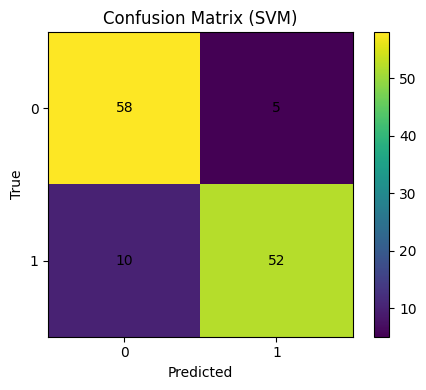

In [ ]:
# Plot confusion matrix using matplotlib and confusion_matrix
cm = confusion_matrix(y_test, y_pred)
fig = plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (SVM)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, [0,1])
plt.yticks(tick_marks, [0,1])
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
cm_path = os.path.join(OUT_DIR, "confusion_matrix.png")
plt.savefig(cm_path, dpi=200)
plt.show()
plt.close(fig)

### Decision Boundary Visualization (PCA 2D)
This cell projects the feature space into two dimensions using PCA and visualizes the decision boundary learned by the SVM. It shows how the model separates classes in a simplified 2D space, helping to understand the classifier's behavior.

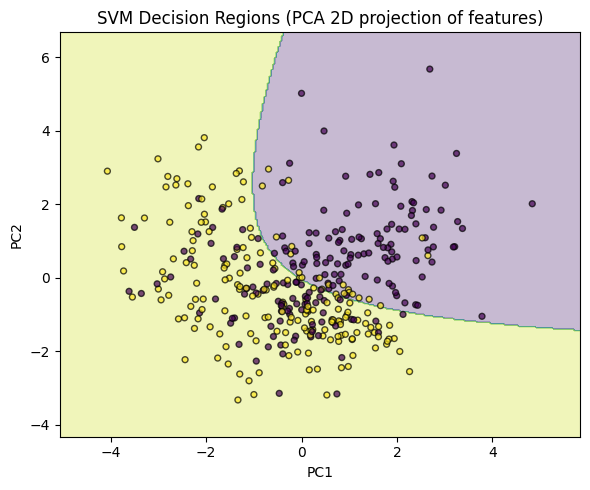

In [ ]:
# Visualize decision boundary in 2D using PCA and SVC
pca = PCA(n_components=2, random_state=42)
X_train_2d = pca.fit_transform(StandardScaler().fit_transform(X_train))
X_test_2d = pca.transform(StandardScaler().fit_transform(X_test))

plot_pipe = Pipeline([
    ("clf", SVC(kernel=best_model.get_params()["clf__kernel"],
                C=best_model.get_params()["clf__C"],
                gamma=best_model.get_params().get("clf__gamma", "scale"),
                probability=True))
])
plot_pipe.fit(X_train_2d, y_train)

x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
Z = plot_pipe.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

fig = plt.figure(figsize=(6,5))
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, s=18, edgecolor="k", alpha=0.7)
plt.title("SVM Decision Regions (PCA 2D projection of features)")
plt.xlabel("PC1")
plt.ylabel("PC2")
db_path = os.path.join(OUT_DIR, "decision_boundary_pca2d.png")
plt.tight_layout()
plt.savefig(db_path, dpi=200)
plt.show()
plt.close(fig)

### ROC Curve Visualization
This cell plots the ROC curve, which illustrates the trade-off between true positive rate and false positive rate at various threshold settings. The area under the curve (AUC) indicates the model's ability to distinguish between classes.

<Figure size 500x400 with 0 Axes>

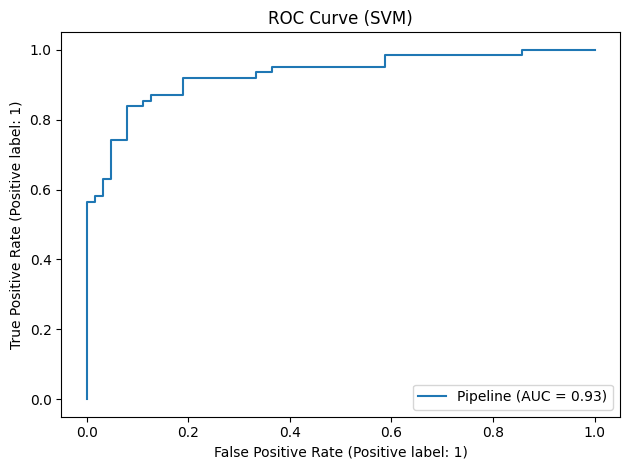

In [ ]:
# Plot ROC curve using RocCurveDisplay
fig = plt.figure(figsize=(5,4))
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title("ROC Curve (SVM)")
roc_path = os.path.join(OUT_DIR, "roc_curve.png")
plt.tight_layout()
plt.savefig(roc_path, dpi=200)
plt.show()
plt.close(fig)

### Learning Curve Visualization
This cell plots the learning curve, showing how model accuracy changes as the training set size increases. It helps diagnose underfitting or overfitting and assesses whether more data could improve performance.

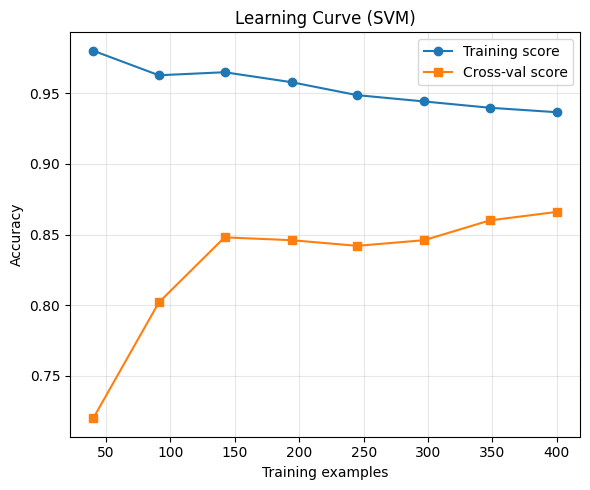

In [10]:
# Plot learning curve using sklearn.learning_curve
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 8), scoring="accuracy"
)
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

fig = plt.figure(figsize=(6,5))
plt.plot(train_sizes, train_mean, marker="o", label="Training score")
plt.plot(train_sizes, test_mean, marker="s", label="Cross-val score")
plt.title("Learning Curve (SVM)")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()
lc_path = os.path.join(OUT_DIR, "learning_curve.png")
plt.tight_layout()
plt.savefig(lc_path, dpi=200)
plt.show()
plt.close(fig)

### Saving Experiment Summary
This cell saves a summary of the experiment, including best hyperparameters, test accuracy, and the classification report. Keeping records is essential for reproducibility and future reference.

In [11]:
# Save summary of results to text file
with open(os.path.join(OUT_DIR, "summary.txt"), "w", encoding="utf-8") as f:
    f.write(f"Best Params: {gs.best_params_}\n")
    f.write(f"Test Accuracy: {acc:.3f}\n\n")
    f.write("Classification Report:\n")
    f.write(report)

print(f"\nSaved images to: {OUT_DIR}")
print(" - confusion_matrix.png")
print(" - decision_boundary_pca2d.png")
print(" - roc_curve.png")
print(" - learning_curve.png")
print("Summary saved to summary.txt")


Saved images to: c:\Users\Jeen\Desktop\introai\introai2\introai2
 - confusion_matrix.png
 - decision_boundary_pca2d.png
 - roc_curve.png
 - learning_curve.png
Summary saved to summary.txt
